In [206]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
from datetime import date, timedelta

In [4]:
# Use to get data from the Covid19 table. 
#    columns : a string of column names from the Covid19 table, must be separated by ', '. Eg 'dates, cases'
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_data(columns, HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT ' + columns + ' FROM Covid19 WHERE HR_UID = ' + str(HR_UID))
    results = pd.DataFrame(cursor.fetchall())
    results.columns = columns.split(', ')
    #print(results[:5])
    cursor.close()
    conn.close()
    
    return results

# Use to get all the health indicators for a health region from the Health_Indicators_ODHF table as a dictionary. 
#    HR_UID : a four digit HR ID, as an int or string. Ottawa is 3551
def get_HR_dict(HR_UID):
    conn = sql.connect('../data/hubs.db')
    cursor = conn.cursor()

    cursor.execute('SELECT * FROM Health_Indicators_ODHF WHERE HR_UID == ' + str(HR_UID))
    tuples = cursor.fetchall()
    if len(tuples) == 0:
        print("No HR with that UID")
        return None

    results = [tuples[0][y] for y in range(len(tuples[0]) - 1)]
    keys = [cursor.description[y][0] for y in range(len(cursor.description) - 1)]

    hr_dict = {}
    for key in zip(keys,results):
        hr_dict[key[0]] = key[1]

    return hr_dict

# Plot the data returned by get_HR_data. 
#    df : a dataframe of the from returned by get_HR_data
#    column : name of column (or columns) to plot. If None, then plots all columns. Should be a string of the same form as in get_HR_data
#    hr_name : name of the HR plotted, as a string. Prints the name of the HR in the title.
def plot_frame(df, column = None, hr_name = None):
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

    # Set up the plot
    fig, ax = plt.subplots(figsize = (19,10))
    dates = df['report_date'].apply(lambda x : np.datetime64(x))
    if column == None:
        column = list(df.columns[1:])
    else:
        column = column.split(', ')
    for col in column:
        ax.scatter(dates, df[col])

    # Set the axis
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(days)

    # Set the axis ranges
    datemin = dates[0]
    datemax = dates[len(dates) - 1]
    ax.set_xlim(datemin, datemax)

    # More axis stuff
    ax.format_xdata = mdates.DateFormatter("%m-%d")
    ax.grid(True)
    fig.autofmt_xdate()
    
    plt.title("Data about " + ", ".join(column) + " by day" + ("" if hr_name == None else ' in ' + hr_name), fontdict = {'fontsize': 20} )
    plt.legend(column, fontsize = 15)

    return fig, ax, plt


In [11]:
ott_dict = get_HR_dict(3551)
ott_dict

{'HR_UID': '3551',
 'ambulatory': 63,
 'hospitals': 19,
 'nursing_residential': 150,
 'Perceived_health_good': 0.66,
 'Perceived_health_poor': 0.077,
 'Diabetes': 0.052,
 'Asthma': 0.102,
 'Physical_activity_150mins_adult': 0.664,
 'Physical_activity_60mins_teen': 0.611,
 'Reg_healthcare_provide': 0.882,
 'Influenza_immunization': 0.4,
 'Propo_Population_CA_CMA': 1.0,
 'Ttl_Population_CA_CMA': 934240,
 'Ttl_Rural_population': 64750,
 'Propo_Population_Rural': 0.069,
 'Immigrant_population': 0.236,
 'Dependency_ratio': 0.601,
 'Unemployment_rate': 0.057,
 'Population_rate': 934245,
 'Population_density': 334.8,
 'Cancer_Incidence': 496.1,
 'Birth_low_weight': 0.062,
 'Birth_high_weight': 0.018,
 'Mortality': 581.3}

In [12]:
df = get_HR_data('report_date, cases, deaths', 3551) # 3551 is Ottawa
df.head()

report_date  cases  deaths
0  2020-01-25      0       0
1  2020-01-26      0       0
2  2020-01-27      0       0
3  2020-01-28      0       0
4  2020-01-29      0       0

(<Figure size 1368x720 with 1 Axes>,
 <module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

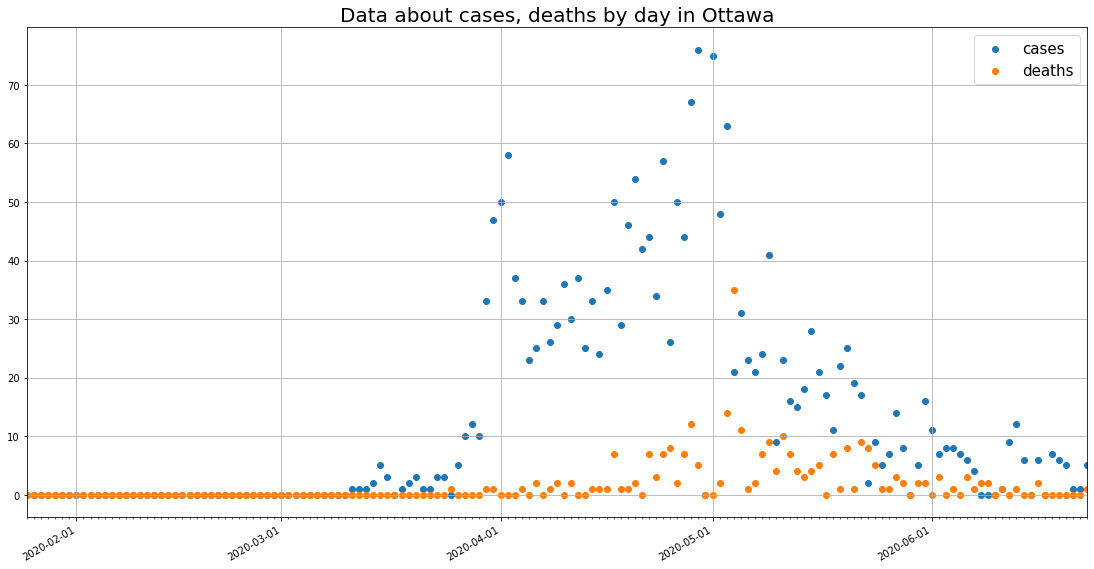

In [13]:
plot_frame(df, 'cases, deaths', 'Ottawa')

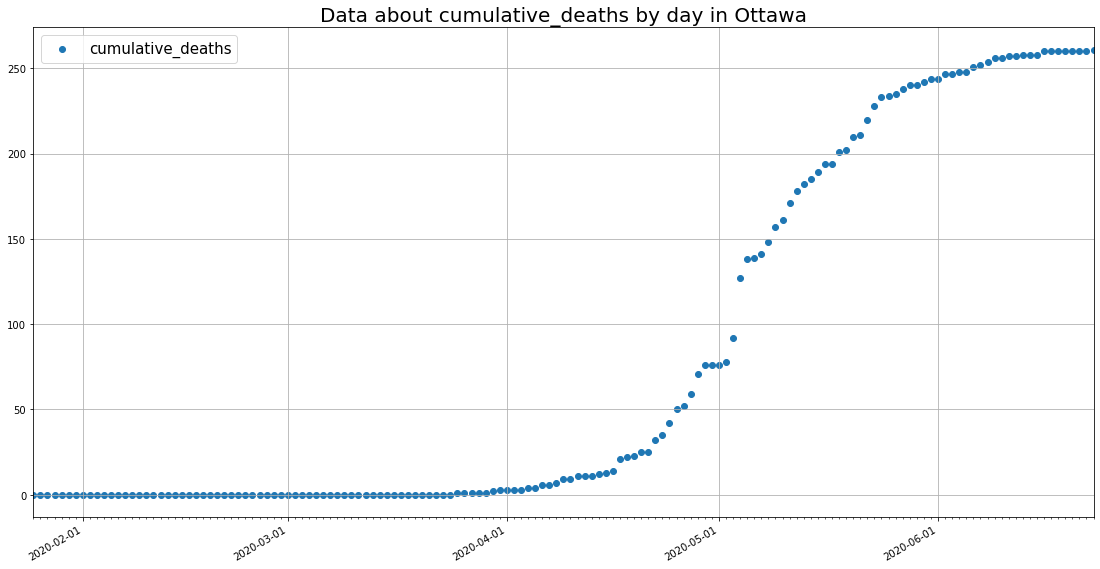

In [14]:
fig3, ax3, plt3 = plot_frame(get_HR_data("report_date, cumulative_deaths", 3551), None, "Ottawa")

This is the data that we will try to fit to in a second.

# Estimating parameters for SEIRS model
Now we try to estimate parameters for a SEIRS model. We need, at the very least, values for beta. I think that in the future, we will try changepoint analysis to separate different 'eras' in the infection, then estimate parameters for every changepoint. The need for this is motivated by the 'cases' plot above for Ottawa

We follow the blog post located here: https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

We will need the lmfit package; `!pip install lmfit` if you haven't updated your images recently.

In [23]:
import lmfit
#from seirsplus.models import *
from scipy.integrate import odeint


In [22]:
!pip install lmfit

     |████████████████████████████████| 258 kB 33.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 882 kB/s  eta 0:00:01
     |████████████████████████████████| 246 kB 61.6 MB/s eta 0:00:01
  Created wheel for lmfit: filename=lmfit-1.0.1-py3-none-any.whl size=81989 sha256=4e5b0ae305e9f270ae79d041f402eba69409e82f509d039a29f4b66b194f923a
  Stored in directory: /home/jovyan/.cache/pip/wheels/d8/b1/40/a92e2a410f0e836855bb3c077e2ee8e6c93adf1898d69aff8c
  Created wheel for asteval: filename=asteval-0.9.18-py3-none-any.whl size=17382 sha256=63a9dd8c76db3205273a36d67fa0d0ef0b223e3ef88c11874c08a63159786294
  Stored in directory: /home/jovyan/.cache/pip/wheels/43/b8/44/8f2a3365bf885f53af98f1528cf7dbc2a8bc81916f678bc045
Successfully built lmfit asteval


We are using a SEIDR model.
Parameters:
- beta $\beta$: rate of transmission.
- delta $\delta$: 1 / incubation period
- rho $\rho$: 1 / time it takes to go from infection to death
- alpha $\alpha$: rate of infected people who die
- gamma $\gamma$: 1 / time it takes to go from infection to recovered

Note that the author of the blog post refers to the symbol 'delta' as 'sigma' throughout. 

We will estimate the value for beta (which changes over time) and use the published data from PHAC to get delta, rho, and gamma. Alpha we will measure from the cases and deaths data from each HR: $\alpha = \frac{d[i]}{c[i - 1/\gamma]}$, where $i$ is the last day of available data, $d$ is the cumulative deaths, $c$ is the cumulative cases. The idea here is we assume that all the cases from $1 / \gamma$ days ago are resolved, either ending in recovery or fatality. 

The first step is to define a function that encodes the model. It should take as an input all parameters, even the ones that need to be estimated, and returns the derivatives over time of all the compartments.
The model is as follows:
$$\frac{dS}{dt} = - SI\beta(t) / N$$
$$\frac{dE}{dt} = SI\beta(t) / N - \delta E$$
$$\frac{dI}{dt} = \delta E - \rho \alpha I - \gamma (1 - \alpha) I$$
$$\frac{dD}{dt} = \rho \alpha I$$
$$\frac{dR}{dt} = \gamma (1 - \alpha) I$$

In [15]:
def deriv(y, t, beta, delta, rho, alpha, gamma, N):
    S, E, I, D, R = y # y wraps up all the compartments
    
    
    dSdt = - S * I * beta(t) / N
    dEdt = S * I * beta(t) / N - delta * E
    dIdt = delta * E - rho * alpha * I - gamma * (1 - alpha) * I
    dDdt = rho * alpha * I
    dRdt = gamma * (1 - alpha) * I
    
    return dSdt, dEdt, dIdt, dDdt, dRdt

We model $R_0$ as a logistic function and we get $\beta$ using the following formula; $R_0 = \frac{\beta}{\gamma}$. We interpret this as 'rate of transmission times length of infectious period'. If someone is infectious for 5 days and transmits to an average of two people per day, then $R_0 = 10$. 

Info on $R_0$: The "reproductive number" that encodes the average number of people who will contract the disease from a single case of the disease. It is affected by multiple factors, such as the rate of contacts in the host population, the probability of transfer given contact, and the duration of infectiousness. 

We model $R_0$ as a logistic curve; this will capture the idea that $R_0$ was high, causing spread, and suddenly lowers when social distancing and other preventative measures finally start having their affect. However, this model can't handle $R_0$ increasing again after restrictions are relaxed. Fortunately, at this time it seems no HR's in Canada are re-increasing in case frequency.

In [87]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start - R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

Messing around with the parameters: the 'switch' is the smooth jump that the logistic function undergoes
- R_0_start: the value before the logistic switch
- R_0_end: the value after the logistic switch
- k: how rapidly the switch occurs, higher is faster
- x0: when the switch occurs; the switch is centred around this value

Note that since this is the model, we are assuming that R_0 decreases at some point and does not increase again. If we want this to be different, we have to change the model or introduce checkpoints.

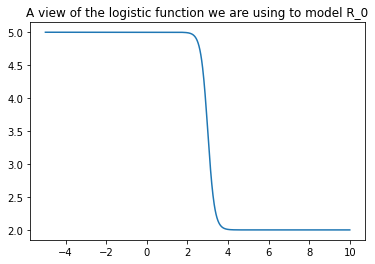

In [90]:
x_exp = np.linspace(-5,10,1000)
y_exp = [logistic_R_0(x_val, R_0_start = 5, k = 6, x0 = 3, R_0_end = 2) for x_val in x_exp]
plt.plot(x_exp, y_exp)
plt.title("A view of the logistic function we are using to model R_0")
plt.show()

Now we can implement the model; this will take the number of days that we want to simulate and all the parameters.
- days: number of days to simulate
- N: total population of region
- R_0_start, R_0_end, k, x: parameters to estimate

In [82]:
# Modelling function
def Model(days, N, R_0_start, k, x0, R_0_end):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    y0 = N - 1.0, 1.0, 0.0, 0.0, 0.0 # Initial population; just one exposed person
    
    t = np.linspace(0, days - 1, days)
    ret = odeint(deriv, y0, t, args=(beta, delta, rho, alpha, gamma, N))
    S, E, I, D, R = ret.T
    
    # this is R_0 throughout for plotting
    R_0_over_time = [beta(i) / gamma for i in range(len(t))]
    beta_over_time = [beta(i) for i in range(len(t))]
    
    return t, S, E, I, D, R, R_0_over_time, beta_over_time

In [24]:
t, S, E, I, D, R, R_0_over_time, beta_over_time = Model(500, 1e6, 4.0, 1.0, 60, 1.0)

In [202]:
def plotting(t, S, E, I, D, R, R_0_over_time, beta_over_time, x_ticks = None):
    f,ax = plt.subplots(1,1,figsize=(15,4))
    ax.title.set_text("SEIDR Model")
    
####!=
    if x_ticks is not None:
        months = mdates.MonthLocator()
        days = mdates.DayLocator()
        years_fmt = mdates.DateFormatter("%Y-%m-%d") # Sets the output format for dates on axis

        # Set up the plot
        dates = x_ticks.apply(lambda x : np.datetime64(x))

        # Set the axis
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(years_fmt)
        ax.xaxis.set_minor_locator(days)

        # Set the axis ranges
        datemin = dates[0]
        datemax = datemin + timedelta(days=len(t) - 1)
        ax.set_xlim(datemin, datemax)

        ax.format_xdata = mdates.DateFormatter("%m-%d")
        #ax.grid(True)
        f.autofmt_xdate()
        
        t = pd.date_range(start = datemin, end = datemax)
####
    def annihilate_small_values(compartment):
        return [compartment[i] if compartment[i] >=1 else 1 for i in range(len(compartment))]

    ax.plot(t, annihilate_small_values(S), 'b', alpha = 0.7, linewidth = 2, label='Susceptible')
    ax.plot(t, annihilate_small_values(E), 'y', alpha = 0.7, linewidth = 2, label='Exposed')
    ax.plot(t, annihilate_small_values(I), 'r', alpha = 0.7, linewidth = 2, label='Infected')
    ax.plot(t, annihilate_small_values(D), 'k', alpha = 0.7, linewidth = 2, label='Dead')
    ax.plot(t, annihilate_small_values(R), 'g', alpha = 0.7, linewidth = 2, label='Recovered')
    ax.set_yscale('log')

    legend = ax.legend()
    ax.grid(b = False, which = 'minor',c='w', lw = 2, ls = '-')

    
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)


    plt.show()

    f = plt.figure(figsize = (15,4))
    # Plot of R_0 over time
    ax1 = f.add_subplot(131)
    ax1.plot(t, R_0_over_time, alpha = 0.7, linewidth=2, label='R_0')
    ax1.title.set_text('Daily R_0 value')
    legend = ax1.legend()
    for spine in ('top','right','bottom','left'):
        ax1.spines[spine].set_visible(False)
    
    # Plot of total infected death rate. Calculated as total deaths divided by everyone who's been infected up to that point.
    # Denominator is calculated as delta * sum(E[:t]), because that is all the people added to the I compartment.
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta * E[:i]) if sum(delta * E[:i]) > 0 else 0 for i in range(1, len(t))]
    ax2.plot(t, total_CFR, alpha = 0.7, linewidth = 2, label = 'Death Rate among Infected')
    legend = ax2.legend()
    ax2.title.set_text("Death Rate %")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax2.spines[spine].set_visible(False)

    # Plot of deaths per day.
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]
    ax3.plot(t, newDs, alpha = 0.7, linewidth=2, label="Daily Deaths")
    ax3.title.set_text("Deaths Per Day")
    for spine in ('top', 'right', 'bottom', 'left'):
            ax3.spines[spine].set_visible(False)
        
    f.autofmt_xdate()
    plt.show()

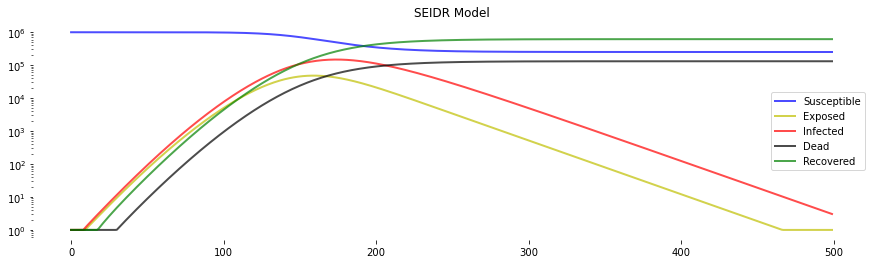

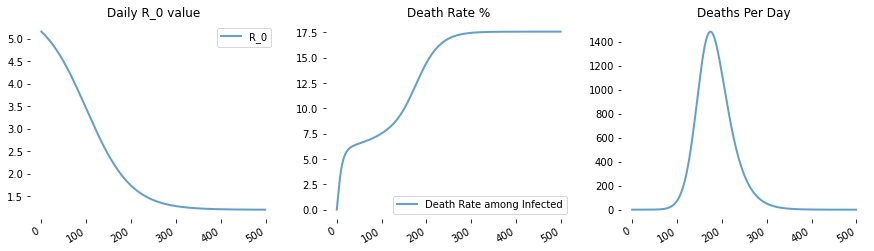

In [204]:
delta = 1 / 5.0 # 1 / incubation period
rho =  1 / 10.0 # 1 / time from I to D
alpha = 0.1 # death rate
gamma = 1.0 / 19.2 # Recall gamma is 1 / time to recover from infection

plotting(*Model(days=500, N=1e6, R_0_start=5.7, k=0.02, x0=100, R_0_end=1.2), x_ticks = None)

The above figure requires some explanation:
- Top plot: A standard SEIDR plot with a log scale. 
- Bottom left: R_0 value, calculated every day. Calculated using $\beta(i) / \gamma$, where $\beta(i)$ is an output of the model.
- Bottom middle: Percentage of infected people who have died.
- Bottom right: Death Rate. Number of new deaths every day.

Now we need a function that computes the model and returns the number of deaths that it predicts; this is because the data we will use to model is death count.

In [31]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    
    return ret[4][x] # return the xth value of Deaths, which is 4 in the return list of Model

This is setting up the model. We need to provide guesses for each of the four parameters, and choose a fit method.

In [32]:
mod = lmfit.Model(fitter)

mod.set_param_hint("R_0_start", value = 5.7, min = 1, max = 15, vary = True)
mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 2.5, vary = True)

params = mod.make_params()
fit_method = 'leastsq'

Now we need to do the fit. First we need to set up our dataset. We take the cumulative death counts for Ottawa and fit to that.

In [207]:
ott_dict = get_HR_dict(3551) # 3551 is Ottawa
print(ott_dict)
df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', 3551) 
print()
print(df.head())
print('The first day of reporting is ' + df['report_date'][0])

{'HR_UID': '3551', 'ambulatory': 63, 'hospitals': 19, 'nursing_residential': 150, 'Perceived_health_good': 0.66, 'Perceived_health_poor': 0.077, 'Diabetes': 0.052, 'Asthma': 0.102, 'Physical_activity_150mins_adult': 0.664, 'Physical_activity_60mins_teen': 0.611, 'Reg_healthcare_provide': 0.882, 'Influenza_immunization': 0.4, 'Propo_Population_CA_CMA': 1.0, 'Ttl_Population_CA_CMA': 934240, 'Ttl_Rural_population': 64750, 'Propo_Population_Rural': 0.069, 'Immigrant_population': 0.236, 'Dependency_ratio': 0.601, 'Unemployment_rate': 0.057, 'Population_rate': 934245, 'Population_density': 334.8, 'Cancer_Incidence': 496.1, 'Birth_low_weight': 0.062, 'Birth_high_weight': 0.018, 'Mortality': 581.3}

  report_date  cumulative_deaths  cumulative_cases
0  2020-01-25                  0                 0
1  2020-01-26                  0                 0
2  2020-01-27                  0                 0
3  2020-01-28                  0                 0
4  2020-01-29                  0            

In [40]:
deaths = np.array(df["cumulative_deaths"])
cases = np.array(df["cumulative_cases"])
days = len(deaths)
x_dat = np.linspace(0,days-1, days, dtype=int)
N = ott_dict["Population_rate"]

In [44]:
delta = 1 / 5.0 # 1 / incubation period
rho =  1 / 10.0 # 1 / time from I to D
gamma = 1.0 / 19.2 # Recall gamma is 1 / time to recover from infection
alpha = deaths[-1] / cases[-(1 + int(np.floor(1 / gamma)))] # death rate

result = mod.fit(deaths, params, method = fit_method, x = x_dat)

In [45]:
result

{'R_0_start': 3.3441633997336555, 'k': 4.914959942990011, 'x0': 98.03834521574609, 'R_0_end': 0.010000000393653879}


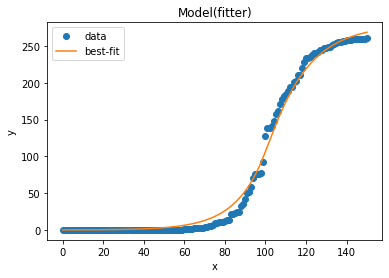

In [93]:
print(result.best_values)

result.plot_fit()

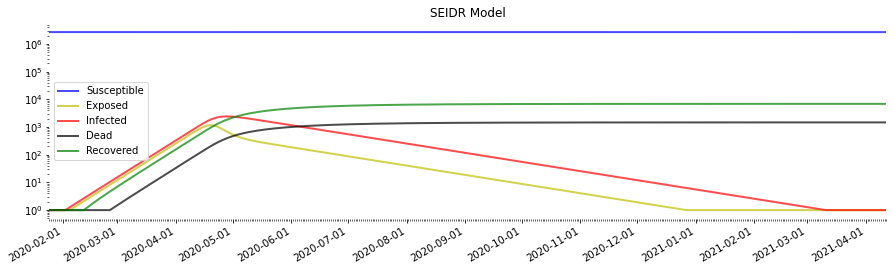

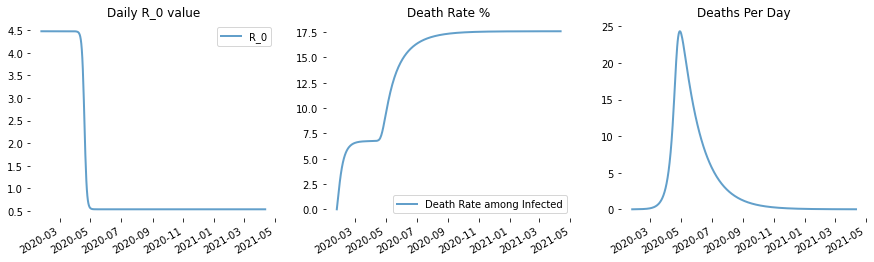

In [208]:
R_0_start, k, x0, R_0_end = result.best_values.values()
plotting(*Model(days=days + 300, N=N, R_0_start=R_0_start, k=k, x0=x0, R_0_end=R_0_end), x_ticks = df['report_date'])

In [94]:
t, S, E, I, D, R, R_0_over_time, beta_over_time = Model(days=days + 300, N=N, R_0_start=R_0_start, k=k, x0=x0, R_0_end=R_0_end)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [102]:
# The largest the Infected compartment ever got
np.floor(np.max(I))

550.0

In [101]:
# The total number of people who ever got infected
np.floor(sum(delta * E))

1241.0

## Now, organize it all so that we can just input an HR and get our data and predictions out. 

In [143]:
mod = lmfit.Model(fitter)

mod.set_param_hint("R_0_start", value = 5.7, min = 1, max = 15, vary = True)
mod.set_param_hint("k", value = 2, min = .001, max = 5, vary = True)
mod.set_param_hint("x0", value = 60, min = 10, max = 150, vary = True)
mod.set_param_hint("R_0_end", value = 1.1, min = 0.01, max = 2.5, vary = True)

params = mod.make_params()
fit_method = 'leastsq'

{'HR_UID': '3551', 'ambulatory': 63, 'hospitals': 19, 'nursing_residential': 150, 'Perceived_health_good': 0.66, 'Perceived_health_poor': 0.077, 'Diabetes': 0.052, 'Asthma': 0.102, 'Physical_activity_150mins_adult': 0.664, 'Physical_activity_60mins_teen': 0.611, 'Reg_healthcare_provide': 0.882, 'Influenza_immunization': 0.4, 'Propo_Population_CA_CMA': 1.0, 'Ttl_Population_CA_CMA': 934240, 'Ttl_Rural_population': 64750, 'Propo_Population_Rural': 0.069, 'Immigrant_population': 0.236, 'Dependency_ratio': 0.601, 'Unemployment_rate': 0.057, 'Population_rate': 934245, 'Population_density': 334.8, 'Cancer_Incidence': 496.1, 'Birth_low_weight': 0.062, 'Birth_high_weight': 0.018, 'Mortality': 581.3}


(<Figure size 1368x720 with 1 Axes>,
 <module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

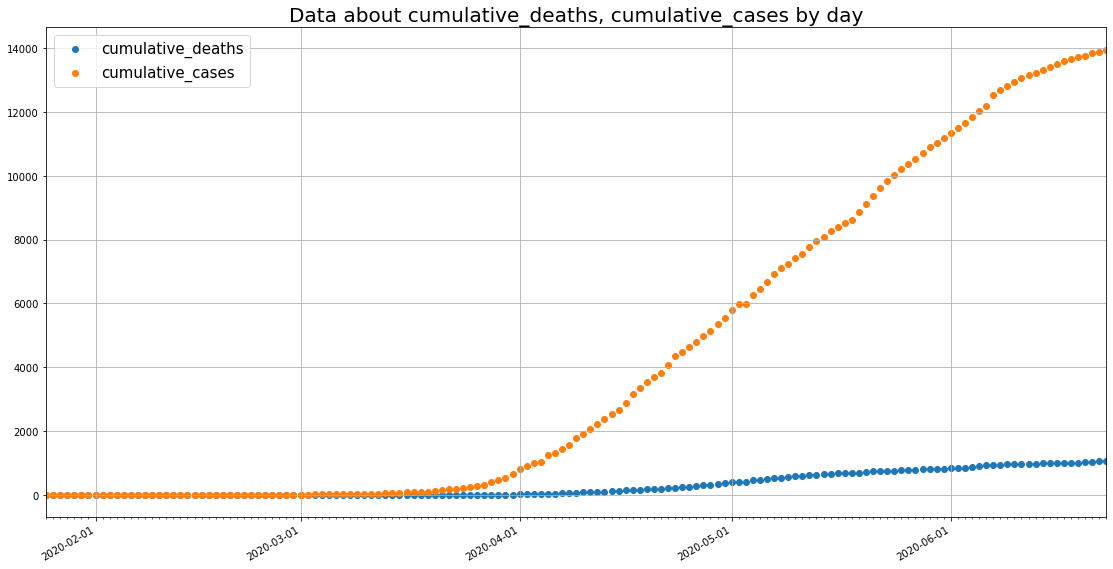

In [145]:
HR_UID = 3595 # 3551 is Ottawa, 3595 is Toronto
hr_dict = get_HR_dict(HR_UID) 
print(dict)
df = get_HR_data('report_date, cumulative_deaths, cumulative_cases', HR_UID) 
df.head()
plot_frame(df)

In [146]:
deaths = np.array(df["cumulative_deaths"])
deaths_less_a_week = deaths[:-7]
cases = np.array(df["cumulative_cases"])
days = len(deaths_less_a_week)
x_dat = np.linspace(0,days-1, days, dtype=int)
N = hr_dict["Population_rate"]

In [147]:
delta = 1 / 5.0 # 1 / incubation period
rho =  1 / 12.0 # 1 / time from I to D
gamma = 1.0 / 19.2 # Recall gamma is 1 / time to recover from infection
alpha = deaths[-1] / cases[-(1 + int(np.floor(1 / gamma)))] # death rate

result = mod.fit(deaths_less_a_week, params, method = fit_method, x = x_dat)

{'R_0_start': 4.476573598925166, 'k': 0.4248212042224906, 'x0': 85.10238873165775, 'R_0_end': 0.5370151237171467}


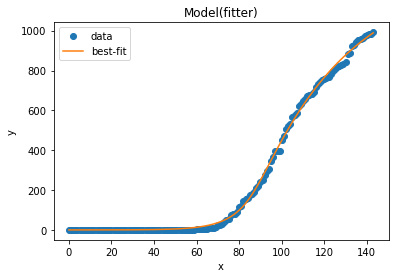

In [148]:
print(result.best_values)

result.plot_fit()

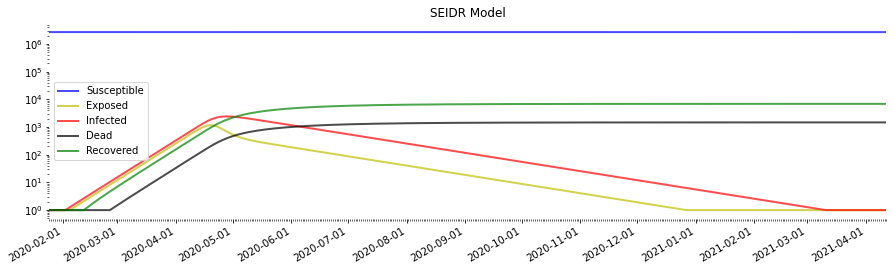

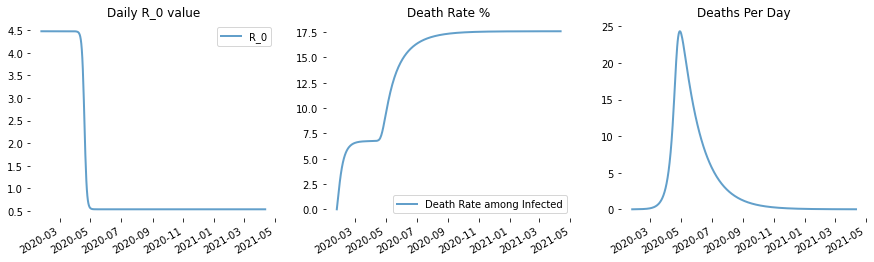

In [210]:
R_0_start, k, x0, R_0_end = result.best_values.values()
model = Model(days=days + 300, N=N, R_0_start=R_0_start, k=k, x0=x0, R_0_end=R_0_end)
t, S, E, I, D, R, R_0_over_time, beta_over_time = model
plotting(*model, x_ticks = df['report_date'])

In [150]:
# The largest the Infected compartment ever got
print("According to the model, the largest number of active infections: " + str(np.floor(np.max(I))))
# The total number of people who ever got infected
print("According to the model, the total number of cases is " + str(np.floor(sum(delta * E))) + ', compared to ' + str(cases[-1]) + ' as reported in the covid data')

According to the model, the largest number of active infections: 2754.0
According to the model, the total number of cases is 9657.0, compared to 13956 as reported in the covid data


## Now, we determine if we are high risk or not;
We compare the true deaths today to what the model would have predicted. If the model predicts more, then we have a low-risk region, and if the model predicts less then we have high-risk.

In [151]:
print('True deaths: ' + str(deaths[-1]))
print('Predicted deaths: ' + str(D[days+7]))
if deaths[-1] > D[days+7]:
    print("Thus, health region " + str(HR_UID) + " is a high-risk HR")
else:
    print("Thus, health region " + str(HR_UID) + " is a low-risk HR")

True deaths: 1052
Predicted deaths: 1042.84254101359
Thus, health region 3595 is a high-risk HR
